<a href="https://colab.research.google.com/github/arashfahim/Stochastic_Control_FSU/blob/main/Discrete_time_DPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/arashfahim/Stochastic_Control_FSU

fatal: destination path 'Stochastic_Control_FSU' already exists and is not an empty directory.


In [2]:
! ls -l

total 12
drwx------ 6 root root 4096 Sep 26 13:46 drive
-rw-r--r-- 1 root root    0 Sep 26 14:20 run_1695737488.7472944
-rw-r--r-- 1 root root    0 Sep 26 14:21 run_1695737488.7472944.csv
drwxr-xr-x 1 root root 4096 Sep 22 13:27 sample_data
drwxr-xr-x 4 root root 4096 Sep 26 13:37 Stochastic_Control_FSU


In [3]:
path = r'/content/Stochastic_Control_FSU/arashfahim/Stochastic_Control_FSU/'

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The goal of this notebook is to implement a one-step dynamic programming principle, DPP, for a stochastic control problem.

The stochastic control problem is given by

$\inf_{u_0,...u_{T-1}}\mathbb{E}\bigg[\sum_{t=0}^{T-1}C(t,X^u_t,u_t)+g(X^u_T)\bigg]$




The DPP is given by

$\begin{cases}
V(t,x)=\inf_{u\in\mathbb{R}^d}\mathbb{E}[C(t,x,u)+V(t+1,X^u_{t+1})]\\
V(T,x)=g(x)
\end{cases}$

with $X^u_{t+1}=x+\mu(t,x,u)+\sigma(t,x,u)\xi_{t+1}$

# Step 1. Creation of optimization module

We need to solve the above one-step optimization problem.

Input: $\phi(x,u,\xi)$ and $c(x,u)$

Optimize: $\inf_u\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$

Output: $u^*(x)\in\textrm{argmin}\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$



---

It is important to make sure the input and output are functions and not just data points.

## Step 1.1. Expected value

To evaluate $\mathbb{E}[c(t,x,u)+\phi(x,\xi)]$ in Step 1, we need to create a module that evaluate expected value using a set of samples of $\xi$.
Such module must evaluate the expected value a a function of $x$. To do this, we use the following two wellknown theorems about conditional expectation


  1) If $X$ and $\xi$ are independent, then $\mathbb{E}[\phi(X,\xi)|X]= \Phi(X)$, where $\Phi(x)=\mathbb{E}[\phi(x,\xi)]$.

  2) $\mathbb{E}[Y|X]=f(X)$, where $f(x)$ is the minimizer of $\mathbb{E}[(Y-f(X))^2]$.



### Example using neural networks

Let's write a module that takes samples of $(X,Y)$ and returns $\mathbb{E}[Y|X=x]$

Example: $X$ standard normal and $Y=e^{-X}+e^X\xi$ where $\xi$ is standard normal independent of $X$.

In [5]:
import torch
import torch.nn as nn
M =1000# number of samples
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)
Y = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))# samples for Y=e^{-x}+e^{x}N(0,1)
# X.shape

In [6]:
model1= torch.nn.Sequential(
    torch.nn.Linear(1, 8),
    torch.nn.ReLU(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(8,1)
)

In [7]:
def loss_fun(y,x,model):# y :samples for $Y$, x: samples for x, model: nn
  return torch.mean(torch.pow(model(x)-y,2))


In [8]:
# loss_fun(Y,X,model1)

In [9]:
import torch.optim as optim
# import torch.optim.lr_scheduler as lr_scheduler

In [10]:
# create time stamp to save the result
import time
from time import strftime, localtime
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))
#create a dataframe to write the loss into
import pandas as pd
import numpy as np

2023-09-26 14:59:56


In [11]:
#hyperparameters for learning
lr = 1e-3
num_epochs = 5000
torch.set_printoptions(precision=10)
loss_epoch = torch.zeros(num_epochs)
optimizer = optim.Adam(model1.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [12]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  loss=loss_fun(Y,X,model1)
  loss.backward()
  optimizer.step()
  loss_epoch[epoch] = loss
  # scheduler.step()
  if (epoch % 1000==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))


At epoch 0 the mean error is 15.092506408691406.
At epoch 1000 the mean error is 6.945650100708008.
At epoch 2000 the mean error is 6.714145183563232.
At epoch 3000 the mean error is 6.602640628814697.
At epoch 4000 the mean error is 6.549546718597412.


In [13]:
#saving the model
torch.save(model1, path+"model1_"+str(stamp)+".pt")

In [14]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model1_"+str(stamp)+".csv",sep=",")

In [15]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

Test on new data: MSE = 15.84597396850586


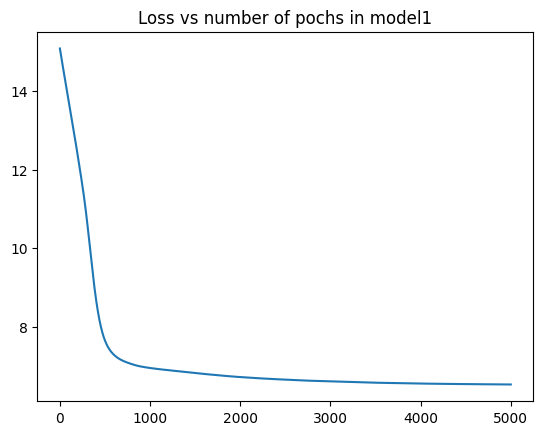

In [16]:
import numpy as np
import matplotlib.pyplot as plt
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of pochs in model1");
plt.savefig(path+'loss_vs_epoch_model1'+stamp+'.png');

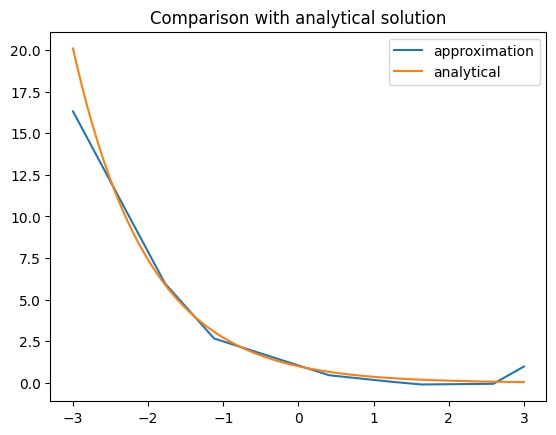

In [17]:
xx = torch.linspace(-3,3,600)
yy = model1(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model1'+stamp+'.png');

In [18]:
# increase neurons
model2= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [19]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

2023-09-26 15:00:11


In [20]:
#hyperparameters for learning
optimizer = optim.Adam(model2.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [21]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  loss=loss_fun(Y,X,model2)
  loss.backward()
  optimizer.step()
  loss_epoch[epoch] = loss
  # scheduler.step()
  if (epoch % 1000==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))


At epoch 0 the mean error is 13.1160888671875.
At epoch 1000 the mean error is 6.88940954208374.
At epoch 2000 the mean error is 6.603552341461182.
At epoch 3000 the mean error is 6.505787372589111.
At epoch 4000 the mean error is 6.471831798553467.


In [22]:
#saving the model
torch.save(model2, path+"model2_"+str(stamp)+".pt")

In [23]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model2_"+str(stamp)+".csv",sep=",")

In [24]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

Test on new data: MSE = 14.342218399047852


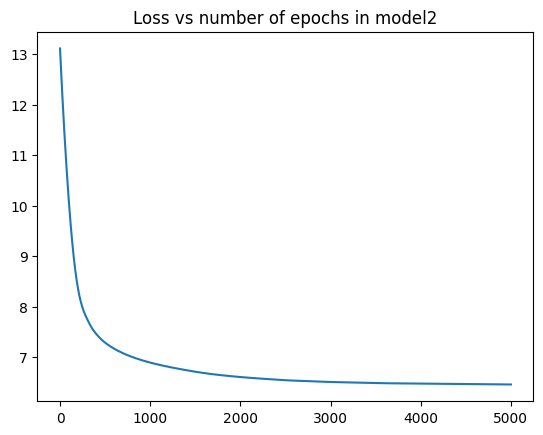

In [25]:
import numpy as np
import matplotlib.pyplot as plt
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of epochs in model2");
plt.savefig(path+'loss_vs_epoch_model2'+stamp+'.png');

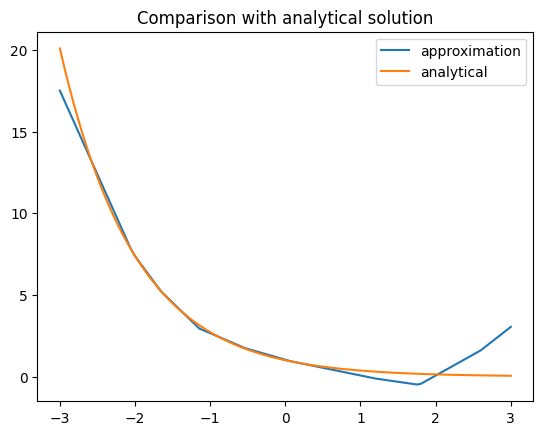

In [26]:
xx = torch.linspace(-3,3,600)
yy = model2(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model2'+stamp+'.png');

In [27]:
## Pro

## 1.2 Projectin method


One trick to approximate $\mathbb{E}[Y|X]=f(X)$ is to take the minimum over a smaller class of fuctions, e.g., $f(x)=\sum_{k=1}^Ka_k\phi_k(x)$, for a suitable set of functions $\phi_k$. To evluate approximate $f$, we use a joint (unconditional) sample of $(X,Y)$, $\{(x_j,y_j):j=i,...,J\}$ to write

$\inf_{a_1,...,a_K}\sum_{j=1}^J \big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)^2$

This is a quadratic minimization problem which has a unique solution. To find the minimizer, we take take derivative wrt $a_{k'}$ and set it to zero to obtain a linear system.

$\sum_{j=1}^J \phi_{k'}(x_j)\big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)=0$

$\sum_{k=1}^Ka_k\sum_{j=1}^J\phi_k(x_j)\phi_{k'}(x_j) = \sum_{j=1}^J \phi_{k'}(x_j)y_j$

or $Ma=b$ with

$a=(a_1,...,a_K)^\top$, $M=[m_{k'k}]$ with $m_{k'k}=\sum_{j=1}^J\phi_{k'}(x_j)\phi_{k}(x_j)$, and $b=(b_1,...,b_K)^\top$ with $b_k=\sum_{j=1}^J\phi_k(x_j)y_j$.

## 1.3. Choosing basis $\phi_k$

It is useful to choose the basis $\phi_k$ such that $m_{k'k}=0$ when $k'\neq k$. Then, the linear system above takes no time to solve: $a_k=b_k/m_{kk}$. Sometimes this is done by using orthogonal polynomials. However, we propose a simpler solution: choose the basis such that $\phi_k(x)$ and $\phi_{k'}(x)$ have disjoint support. For instance, they are indicator functions of hypercubes.
 More detains of this method can be found in the paper [Monte-Carlo valuation of American options: facts and new algorithms to improve existing methods](https://www.ceremade.dauphine.fr/~bouchard/pdf/BW10.pdf).

## 1.3. Simulationg samples of $(X_t,\xi)$
Let $\xi$ be Gaussian, e.g., increment of Brownian motion, we can choose any distribution for $X_t$ independent of $\xi$.

# Step 2 DPP
Start the backward scheme by feeding $C(t,x,u)$ and $g(x)$ into the optimization module and obtain $V(T-1,x)$ over the range of simulated values for $X_{T-1}$.

Repeat the process by feeding $C(t,x,u)$ and $V(t+1,x)$ into the optimization module to obtain $V(t,x)$.

It is important to make sure the simulated samples of $X^u_{t+1}$ are well inside the range in which estimation of $V(t+1,x)$ is rather accurate/